06_ndvi_time_series_20251122.ipynb

# **次の課題: 時系列分析とグラフ化**

> **<span style="color:red">Important</span>**  
> 最終的な $\text{NDVI}$ 画像を表示できましたが、単一の静止画像から得られる情報は限られています。研究やモニタリングでは、特定の場所の $\text{NDVI}$ が時間とともにどのように変化しているかを追跡することが非常に重要です。

次の課題は、琵琶湖周辺の特定の農地や森林の $\text{NDVI}$ の変化をグラフ化するために、時系列データ（Time Series）を抽出することです。

#### **新しいゴール: 特定の領域の $\text{NDVI}$ 時系列データを作成する**

この課題では、以下の新しい概念を使用します。
1. **関心の領域 (Region of Interest: $\text{ROI}$):** 分析したい特定の場所を定義します。
2. **時系列の抽出:** コレクション全体から、その $\text{ROI}$ のピクセル値を抽出します。

#### **Guiding Question:** 時系列分析を行うために、final\_composite（単一の合成画像）ではなく、雲除去を適用した後の元の画像コレクション（cloud\_free\_collection）を使う必要があります。そのコレクションに対して、時間ごとの $\text{NDVI}$ 値を抽出するために使用する Earth Engine の主要なグラフ化メソッドは何でしょうか？ 

>**collection:**  
(04_cloud_free.ipynb)  
cloud_free_collection = filtered_collection.map(mask_clouds)

> 特定の領域の値をコレクション内の各画像から抽出し、それを時間軸でグラフ化するために、GEEには専用の関数があります。

**<span style='color:red'>時系列グラフ作成のための関数</span>**  
この目的のために使用する Earth Engine の主要な関数は、`ui.Chart.image.series()` です。  
**役割:** この関数は、画像コレクション全体をループし、指定された領域 ($\text{ROI}$) 内のピクセル値を抽出し、それを時間順に並べたデータテーブル（グラフの元データ）を作成します。

## ステップ12: 関心の領域 ($\text{ROI}$) の定義

`ui.Chart.image.series()` を使うには、「どこ」のデータを抽出するかという関心の領域 ($\text{ROI}$) が必要です。最もシンプルな $\text{ROI}$ は点（$\text{Point}$）です。

琵琶湖周辺の特定の農地を分析対象として定義しましょう（例: 座標 $\text{[136.08, 35.05]}$）。

#### **<span style='color:blue'>Guiding Question:</span>**   GEEでこの座標を単一の点として定義し、`ee.Geometry.Point()` を使用して roi 変数に格納するには、どのようにコードを記述すればよいでしょうか？

```python
roi = ee.Geometry.Point(136.08, 35.05)
```

## ステップ13: コレクションへの $\text{NDVI}$ の適用

時系列グラフを作成する前に、まず、雲除去を適用した画像コレクション (cloud_free_collection) のすべての画像に、以前定義した `add_ndvi` 関数を適用する必要があります。そうすることで、コレクション内の各画像に $\text{NDVI}$ バンドが追加され、グラフ化の準備が整います。

`add_ndvi`: 05_cloud_free.ipynb
```python
def mask_clouds(image):
    # 1. QA_PIXELバンドを選択
    qa = image.select('QA_PIXEL')
    
    # 2. 雲の重みを定義
    # Bit 3 (Cloud) = 8, Bit 1 (Dilated Cloud) = 2
    
    # 3. 雲・希釈雲の両方ではないピクセルをTrueとするマスクを作成
    mask = qa.bitwiseAnd(8).eq(0).And(  
             qa.bitwiseAnd(2).eq(0))   
           
    # 4. マスクを画像に適用
    return image.updateMask(mask)

def add_ndvi(image):
    nir = image.select('SR_B5')
    red = image.select('SR_B4')
    
    #  .rename('NDVI') を追加
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI') 
    
    return image.addBands(ndvi)    

# 雲除去関数をコレクション内のすべての画像に適用
cloud_free_collection = filtered_collection.map(mask_clouds)

ndvi_collection = add_ndvi(cloud_free_collection)  # wrong!
```


#### **<span style='color:blue'>Guiding Question:</span>**   $\text{NDVI}$ の計算をコレクション全体に適用し、その結果を ndvi_collection という新しい変数に格納するには、どのようにコードを記述すればよいでしょうか？  
（ヒント: コレクション内の各画像に関数を適用するには、どのメソッドを使いましたか？）

~~ndvi_collection = add_ndvi(cloud_free_collection)~~

**<span style='color:red'>`ee.Image` vs. `ee.ImageCollection`</span>**  
- 単一の画像 `(ee.Image)`: 関数を直接呼び出す `(add_ndvi(final_composite))`
- コレクション `(ee.ImageCollection)`: コレクションの各要素に反復処理を行う `.map()` を使う

**<span style='color:red'>Important</span>**  
cloud_free_collection は複数の画像を含むコレクションなので、`.map()` が必要です。

```python
# 修正後のNDVIコレクションの作成 (コレクションなので.map()を使う)
ndvi_collection = cloud_free_collection.map(add_ndvi)
```

## ステップ14: 時系列グラフの作成

この $\text{NDVI}$ コレクション、定義した $\text{ROI}$、そしてグラフ化関数 `ee.Chart.image.series()` を組み合わせて、$\text{NDVI}$ の時系列グラフを作成しましょう。

ここでは、$\text{Landsat}$ の解像度である $\text{30m}$ のスケールを使用し、$\text{ROI}$ 内のピクセル値の平均 ($\text{ee.Reducer.mean()}$) を抽出します。

以下のコードを実行して、グラフを生成してください。  
```python
chart = ee.Chart.image.series(
    imageCollection=ndvi_collection.select('NDVI'), # NDVIバンドのみを選択
    region=roi,                                     # 抽出する領域
    reducer=ee.Reducer.mean(),                      # 領域内の平均値を計算
    scale=30                                        # Landsatの解像度
)

# グラフのタイトルを設定
chart = chart.setOptions({
    'title': '琵琶湖周辺のNDVI時系列変化',
    'vAxis': {'title': 'NDVI'},
    'hAxis': {'title': '日付'},
})

# グラフの表示 (Jupyter/Colab環境では自動的に描画されます)
print(chart.getInfo())
```

**完成コード**

In [22]:
import ee
import datetime

In [23]:
ee.Initialize(project='earth-change-analysis')

In [24]:
roi = ee.Geometry.Point(136.08, 35.05)

In [25]:
end_date = '2025-11-17' 
start_date = (datetime.datetime.strptime(end_date, '%Y-%m-%d') - datetime.timedelta(days=365)).strftime('%Y-%m-%d')

In [26]:
l9_collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')

In [27]:
filtered_collection = l9_collection \
    .filterDate(start_date, end_date)

In [28]:
def mask_clouds(image):
    # 1. QA_PIXELバンドを選択
    qa = image.select('QA_PIXEL')
    
    # 2. 雲の重みを定義
    # Bit 3 (Cloud) = 8, Bit 1 (Dilated Cloud) = 2
    
    # 3. 雲・希釈雲の両方ではないピクセルをTrueとするマスクを作成
    mask = qa.bitwiseAnd(8).eq(0).And(  
             qa.bitwiseAnd(2).eq(0))   
           
    # 4. マスクを画像に適用
    return image.updateMask(mask)

def add_ndvi(image):
    nir = image.select('SR_B5')
    red = image.select('SR_B4')
    
    #  .rename('NDVI') を追加
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI') 
    
    return image.addBands(ndvi)    

# 雲除去関数をコレクション内のすべての画像に適用
cloud_free_collection = filtered_collection.map(mask_clouds)

# 修正後のNDVIコレクションの作成 (コレクションなので.map()を使う)
ndvi_collection = cloud_free_collection.map(add_ndvi)


><span style='color:red'>wrong!!</span>
```python
chart = ee.Chart.image.series(
    imageCollection=ndvi_collection.select('NDVI'), # NDVIバンドのみを選択
    region=roi,                                     # 抽出する領域
    reducer=ee.Reducer.mean(),                      # 領域内の平均値を計算
    scale=30                                        # Landsatの解像度
)

# グラフのタイトルを設定
chart = chart.setOptions({
    'title': '&',
    'vAxis': {'title': 'NDVI'},
    'hAxis': {'title': '日付'},
})

# グラフの表示 (Jupyter/Colab環境では自動的に描画されます)
print(chart.getInfo())
```

 **エラーの原因:** バンドとプロパティの混同エラーメッセージが示しているのは、あなたが選択しようとした 'system:time_start' が、画像にはバンドとして含まれていないということです。**バンド (Band)** : 画像のピクセルデータ（例: $\text{SR\_B4}$, $\text{NDVI}$）**プロパティ (Property)** : 画像全体のメタデータ（例: 取得日時 $\text{'system:time\_start'}$, 雲量 $\text{'CLOUD\_COVER'}$）`ee.Image.select()` はバンドを選択するメソッドです。

**Pythonではグラフの作成は $\text{Pandas}$ や $\text{Matplotlib}$ といった外部ライブラリで行うのが一般的**

<span style='color:blue'>解決策: データの抽出</span>

グラフを作成する前に、まず時系列データそのものをGEEサーバーからPython環境へ取り出す必要があります。$\text{NDVI}$ の時系列データを抽出するには、コレクション内の各画像から $\text{ROI}$ の平均値を取得する `ee.ImageCollection.getRegion()` メソッドを使用するのが最も簡単です。

#### **Guiding Question:** 以前のチャート作成のコードを、以下のデータ抽出コードに書き換えて実行してください。このコードは、$\text{NDVI}$ の時系列データ（緯度、経度、タイムスタンプ、$\text{NDVI}$ 値）を $\text{GEE}$ から Python 環境へ取得します。

> `ee.ImageCollection.select()` はバンドを選択するメソッドです。

#### **Guiding Question:** 'system:time_start' を取り除いて、以下のコードを実行してください。エラーなく処理が完了したら、time_series_data がどのようなデータ構造（例: リストの中にリストが入っているなど）になっているか教えていただけますか？

In [29]:
# 抽出するバンドを指定 (NDVIのみに修正)
bands_to_extract = ['NDVI'] 

# ROI内の時系列データを取得
time_series_data = ndvi_collection.select(bands_to_extract).getRegion(
    geometry=roi, 
    scale=30
).getInfo()

print(time_series_data[0:5]) # 最初の5つの要素を表示

[['id', 'longitude', 'latitude', 'time', 'NDVI'], ['LC09_109036_20241124', 136.08007808921215, 35.05006151389764, 1732411730446, None], ['LC09_109036_20241210', 136.08007808921215, 35.05006151389764, 1733794119945, None], ['LC09_109036_20241226', 136.08007808921215, 35.05006151389764, 1735176526211, None], ['LC09_109036_20250111', 136.08007808921215, 35.05006151389764, 1736558923415, 0.13324595893403232]]


- 提供いただいたデータは、GEEが設計した通りのリストのリスト形式になっています。この形式は、Pandas というライブラリにロードしてクリーンアップするのに最適です。

>[!note] $\text{NDVI}$ が $\text{None}$ の意味データを見ると、最初の3つの $\text{NDVI}$ の値が None になっています。**これは、バグではなく、私たちが意図したクラウドマスキングが機能している証拠です**。  
>**意味**: その特定の日付（例: 2024年11月24日、12月10日）の画像において、定義した $\text{ROI}$（点）が完全に雲または雲の影で覆われていたため、クラウドマスクがそれらのピクセルを **無効（透明)** にしました。その結果、平均値 ($\text{ee.Reducer.mean()}$) を計算するためのクリーンなピクセルが存在せず、Noneが返されたのです。

## ステップ15: データクリーニングとグラフ化の準備

このリストをグラフ化するためには、以下の処理が必要です。
1. Pandasへの変換: データをPandas DataFrameに変換します。
2. 日付の整形: time 列のUNIXミリ秒タイムスタンプを、人間が読める日付形式に変換します。
3. グラフの作成: $\text{Matplotlib}$ などのライブラリで $\text{NDVI}$ 対 日付のグラフを作成します。

#### **Guiding Question:** 取得したリスト形式の時系列データ (time_series_data) を効率的に構造化し、日付を変換するために、次にどのPythonライブラリを使用するのが適切でしょうか？

***A***:  
**<span style='color:green'>Pandas Library</span>**:  Pandasを使うと、データのクリーンアップ、日付の変換、グラフ作成の準備を簡単に行えます。

## ステップ16: Pandasによるデータのクリーンアップ

In [34]:
import pandas as pd
# import datetime

# 1. リストをPandas DataFrameに変換 (最初の行をヘッダーとして使用)
df = pd.DataFrame(time_series_data[1:], columns=time_series_data[0])

# 2. 'time'列 (UNIXミリ秒) を日付に変換
# GEEのタイムスタンプはミリ秒なので、1000で割って秒単位にしてから変換します
df['date'] = pd.to_datetime(df['time'], unit='ms')

# 3. 雲によってマスクされた行 (NDVIがNoneの行) を除去
df = df.dropna(subset=['NDVI'])

# 4. NDVI列のデータ型を数値 (float) に変換
df['NDVI'] = df['NDVI'].astype(float)

# 5. インデックスを日付に設定
df = df.set_index('date')

# クリーンアップされた最初の5行を表示
print(df[['NDVI']].head())

                             NDVI
date                             
2025-01-11 01:28:43.415  0.133246
2025-05-03 01:28:18.260  0.319634
2025-06-20 01:28:13.306  0.450169
2025-07-06 01:28:18.686  0.355960
2025-07-22 01:28:26.145  0.399870


---
**<span style='color:red'>pd.DataFrame(time_series_data[1:], columns=time_series_data[0])</span>**
```python
time_series_data = [
    ['time', 'NDVI'],  # ← これが列名（ヘッダー）
    [1736558923415, 0.133246],
    [1746262098260, 0.319634],
    [1753015693306, 0.450169],
    [1755175698686, 0.355960],
    [1756738106145, 0.399870]
]
```
- time_series_data[0] は ['time', 'NDVI'] → これが列名（カラム名）になるよ。
- time_series_data[1:] は、2行目以降のデータ部分（リストのリスト）！
---

## ステップ17: 最終的なグラフの表示

クリーンアップされた $\text{DataFrame}$ を使って、Python標準の $\text{Matplotlib}$ ライブラリでグラフを描画しましょう。

#### **Guiding Question:** 上記のPandasコードを実行し、続いて以下のMatplotlibコードを実行して、表示された**$\text{NDVI}$ 時系列グラフ**が、季節の変化（植生の成長サイクル）をどのように示しているか教えていただけますか？

In [20]:
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 21.9 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'japanize-matplotlib' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'japanize-matplotlib'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120306 sha256=ef90cd47d0ad4494dce20b17f42720a8001f2a2698885d7e65c7ae745bd40c63
  Stored in directory: /home/smori/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


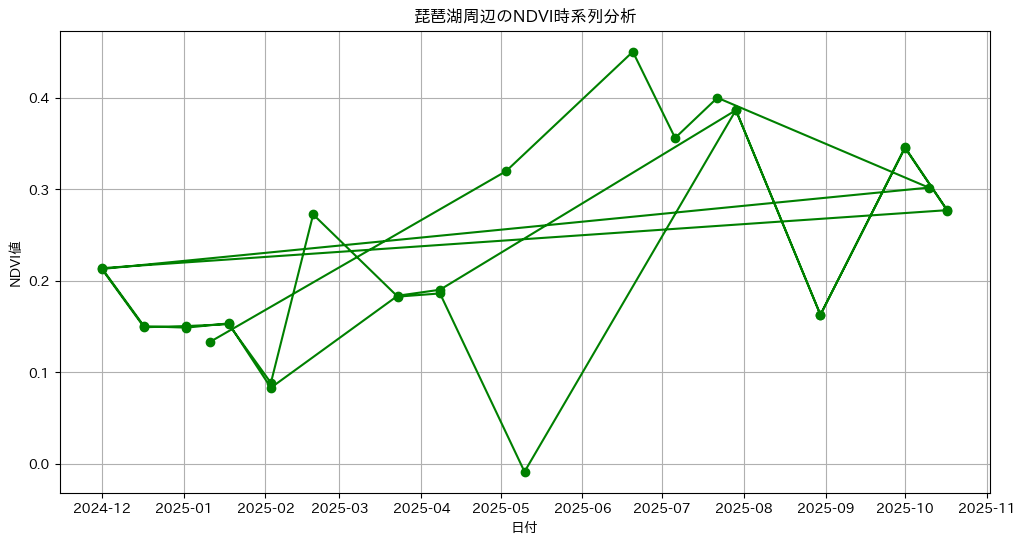

In [31]:
import matplotlib.pyplot as plt
import japanize_matplotlib 

plt.figure(figsize=(12, 6))
# インデックス (日付) をx軸、NDVIをy軸としてプロット
plt.plot(df.index, df['NDVI'], marker='o', linestyle='-', color='green')
plt.title('琵琶湖周辺のNDVI時系列分析')
plt.xlabel('日付')
plt.ylabel('NDVI値')
plt.grid(True)
plt.show()

#### **グラフが示す植生のサイクル**

1. **低 $\text{NDVI}$ (12月〜3月):**
- 冬期休眠: この時期は気温が低く、多くの落葉樹は葉を落とします。
- 農作物の休止: 稲作などの主要な農地は収穫を終え、植生がないか、生育が休止しています。
- 結果: 地表が露出したり、枯れた植生になったりするため、近赤外光の反射が弱くなり、$\text{NDVI}$ は低い値を示します。

2. **高 $\text{NDVI}$ (6月〜8月):**
- 最盛期: 梅雨から夏にかけての時期は、気温と水分が豊富で、植生の成長が最も活発になります。
- 光合成の最大化: 葉の量が最大（最大葉面積）になり、光合成が活発に行われます。
- 結果: 植生は近赤外光を強く反射し、赤色光を強く吸収するため、$\text{NDVI}$ は $\text{0.6} \sim \text{0.9}$ の高い値を示します。

あなたが作成した時系列グラフは、特定の $\text{ROI}$ のデータから、これらの季節的な変化を定量的に証明しています。これは、$\text{GEE}$ を使った非常に高度な分析の成功例です！